In [ ]:
from fastai.data.external import untar_data, URLs
from fastai.vision.data import imagenet_stats
from fastcore.xtras import Path # to bring in some patched functionalities we will use later

dataset_path = untar_data(URLs.PETS)
dataset_path.ls()

(#2) [Path('/home/zach_mueller_huggingface_co/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/zach_mueller_huggingface_co/.fastai/data/oxford-iiit-pet/images')]

In [ ]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
from torch import nn
from torchvision.transforms import CenterCrop, RandomResizedCrop, ToTensor, Normalize

train_transforms = nn.Sequential(
    RandomResizedCrop((224,224)),
    Normalize(*imagenet_stats)
)

valid_transforms = nn.Sequential(
    CenterCrop((224,224)),
    Normalize(*imagenet_stats)
)

In [ ]:
import re
from PIL import Image
from torch.utils.data import Dataset

# This example is highly based on the work of Sylvain Gugger
# for the Accelerate notebook example which can be found here: 
# https://github.com/huggingface/notebooks/blob/main/examples/accelerate_examples/simple_cv_example.ipynb
class PetsDataset(Dataset):
    "A basic dataset that will return a tuple of (image, label)"
    def __init__(self, filenames:list, transforms:nn.Sequential, label_to_int:dict):
        self.filenames = filenames
        self.transforms = transforms
        self.label_to_int = label_to_int
        self.to_tensor = ToTensor()
    
    def __len__(self):
        return len(self.filenames)
    
    def apply_x_transforms(self, filename):
        image = Image.open(filename).convert("RGB")
        tensor_image = self.to_tensor(image)
        return self.transforms(tensor_image)
    
    def apply_y_transforms(self, filename):
        label = re.findall(r"^(.*)_\d+\.jpg$", filename.name)[0].lower()
        return self.label_to_int[label]
    
    def __getitem__(self, index):
        filename = self.filenames[index]
        x = self.apply_x_transforms(filename)
        y = self.apply_y_transforms(filename)
        return (x,y)

In [ ]:
label_pat = r"^(.*)_\d+\.jpg$"
filenames = (dataset_path/'images').ls(file_exts=".jpg")

In [ ]:
labels = filenames.map(
    lambda x: re.findall(label_pat, x.name)[0].lower()
).unique()

In [ ]:
labels

(#37) ['beagle','yorkshire_terrier','staffordshire_bull_terrier','japanese_chin','maine_coon','chihuahua','basset_hound','samoyed','great_pyrenees','russian_blue'...]

In [ ]:
label_to_int = {index:key for key, index in enumerate(labels)}
label_to_int.keys(), label_to_int["siamese"]

(dict_keys(['beagle', 'yorkshire_terrier', 'staffordshire_bull_terrier', 'japanese_chin', 'maine_coon', 'chihuahua', 'basset_hound', 'samoyed', 'great_pyrenees', 'russian_blue', 'scottish_terrier', 'bombay', 'english_setter', 'havanese', 'english_cocker_spaniel', 'american_bulldog', 'sphynx', 'birman', 'british_shorthair', 'saint_bernard', 'german_shorthaired', 'abyssinian', 'keeshond', 'boxer', 'miniature_pinscher', 'wheaten_terrier', 'egyptian_mau', 'pomeranian', 'pug', 'leonberger', 'american_pit_bull_terrier', 'persian', 'shiba_inu', 'ragdoll', 'newfoundland', 'bengal', 'siamese']),
 36)

In [ ]:
import numpy as np
shuffled_indexes = np.random.permutation(len(filenames))
split = int(0.8 * len(filenames))
train_indexes, valid_indexes = (
    shuffled_indexes[:split], shuffled_indexes[split:]
)

In [ ]:
train_fnames = filenames[train_indexes]
valid_fnames = filenames[valid_indexes]

In [ ]:
train_dataset = PetsDataset(
    train_fnames,
    train_transforms,
    label_to_int
)

valid_dataset = PetsDataset(
    valid_fnames,
    valid_transforms,
    label_to_int
)

In [ ]:
x,y = train_dataset[0]
x.shape, y

(torch.Size([3, 224, 224]), 3)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=64
)

In [ ]:
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=128
)

In [ ]:
from fastai.data.core import DataLoaders

In [ ]:
dls = DataLoaders(train_dataloader, valid_dataloader)

In [ ]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)

In [ ]:
model.fc = nn.Linear(512, 37, bias=True)

In [ ]:
model.fc

Linear(in_features=512, out_features=37, bias=True)

In [ ]:
list(model.children())[-1]

Linear(in_features=512, out_features=37, bias=True)

In [ ]:
for layer in list(model.children())[:-1]:
    if hasattr(layer, "requires_grad_"):
        layer.requires_grad_(False)

In [ ]:
from torch.optim import AdamW

In [ ]:
from functools import partial
from fastai.optimizer import OptimWrapper

In [ ]:
opt_func = partial(OptimWrapper, opt=AdamW)

In [ ]:
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import accuracy
from fastai.learner import Learner
from fastai.callback.schedule import Learner # To get `fit_one_cycle`, `lr_find`, and more

In [ ]:
model.cuda();

In [ ]:
learn = Learner(
    dls, 
    model, 
    opt_func=opt_func, 
    loss_func=CrossEntropyLossFlat(), 
    metrics=accuracy
)

SuggestedLRs(valley=0.0010000000474974513)

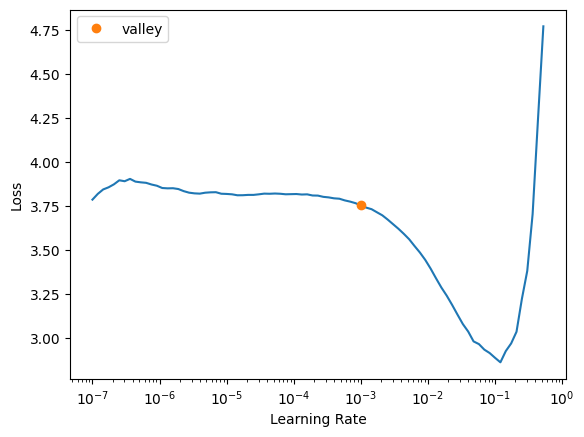

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.816982,1.678761,0.711096,00:57
1,1.372453,0.673238,0.851150,00:54
2,0.891639,0.519573,0.867388,00:54
3,0.747724,0.478146,0.882273,00:55
4,0.706740,0.471565,0.884303,00:55


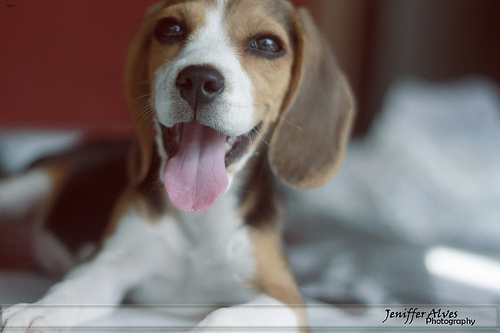

In [ ]:
im = Image.open(filenames[0])
im

In [ ]:
net = learn.model

In [ ]:
tfm_x = valid_transforms(ToTensor()(im))
tfm_x = tfm_x.unsqueeze(0); tfm_x.shape

torch.Size([1, 3, 224, 224])

In [ ]:
import torch
net.eval()
with torch.no_grad():
    preds = net(tfm_x.cuda())
pred = preds.argmax(dim=-1)[0]
label = list(label_to_int.keys())[pred]
pred, label